# Super Store US – Data Exploration

## Dataset Overview

The dataset consists of three sheets from a US Super Store, covering order transactions, returns, and regional management information.

### 1. Orders (1,952 rows, 25 columns)

Contains transactional-level data required to analyze sales performance and profitability.

**Key fields include:**
- **Order ID**: Unique identifier for each order  
- **Customer ID, Customer Name**: Customer-level details  
- **Product Category, Sub-Category, Product Name**: Product hierarchy  
- **Sales, Profit, Discount, Quantity**: Core business metrics  
- **Region, State or Province, City**: Geographic attributes  
- **Order Date, Ship Date**: Time-based analysis fields  

**Note:**  
Some orders generate negative profit, potentially due to high discounts, returns, or operational costs exceeding sales revenue. These loss-making orders are a key focus of the profitability analysis.

---

### 2. Returns (1,634 rows, 2 columns)

Contains information about returned orders.

**Key fields include:**
- **Order ID**: Links returned records to the Orders dataset  
- **Status**: Indicates whether an order was returned  

This sheet is used to evaluate the impact of returns on profitability and sales performance.

---

### 3. Users (4 rows, 2 columns)

Contains regional management information.

**Key fields include:**
- **Region**: Sales region  
- **Manager**: Regional manager responsible for performance  

This data enables analysis of sales and profitability across managerial ownership.

---

## Goal of the Analysis

The objectives of this analysis are to:
- Understand relationships between orders, returns, and regional management
- Prepare a clean, unified dataset for analysis and visualization
- Identify drivers of profitability, losses, discounts, and returns
- Deliver actionable insights through interactive Power BI dashboards for stakeholders


In [6]:
import pandas as pd


file_path = "../data/super_store_us.xlsx"


orders_df = pd.read_excel(file_path, sheet_name="Orders")
returns_df = pd.read_excel(file_path, sheet_name="Returns")
users_df = pd.read_excel(file_path, sheet_name="Users")


orders_df.head(), returns_df.head(), users_df.head()


(   Row ID Order Priority  Discount  Unit Price  Shipping Cost  Customer ID  \
 0   20847           High      0.01        2.84           0.93            3   
 1   20228  Not Specified      0.02      500.98          26.00            5   
 2   21776       Critical      0.06        9.48           7.29           11   
 3   24844         Medium      0.09       78.69          19.99           14   
 4   24846         Medium      0.08        3.28           2.31           14   
 
        Customer Name       Ship Mode Customer Segment Product Category  ...  \
 0      Bonnie Potter     Express Air        Corporate  Office Supplies  ...   
 1     Ronnie Proctor  Delivery Truck      Home Office        Furniture  ...   
 2      Marcus Dunlap     Regular Air      Home Office        Furniture  ...   
 3  Gwendolyn F Tyson     Regular Air   Small Business        Furniture  ...   
 4  Gwendolyn F Tyson     Regular Air   Small Business  Office Supplies  ...   
 
     Region State or Province         City

Below i inspect the structure, data types, and missing values across all tables.


In [7]:
orders_df.info()
returns_df.info()
users_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1952 entries, 0 to 1951
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Row ID                1952 non-null   int64         
 1   Order Priority        1952 non-null   str           
 2   Discount              1952 non-null   float64       
 3   Unit Price            1952 non-null   float64       
 4   Shipping Cost         1952 non-null   float64       
 5   Customer ID           1952 non-null   int64         
 6   Customer Name         1952 non-null   str           
 7   Ship Mode             1952 non-null   str           
 8   Customer Segment      1952 non-null   str           
 9   Product Category      1952 non-null   str           
 10  Product Sub-Category  1952 non-null   str           
 11  Product Container     1952 non-null   str           
 12  Product Name          1952 non-null   str           
 13  Product Base Margin   1936 no

In [ ]:
# Returned flag
returns_df["Returned"] = returns_df["Status"].apply(
    lambda x: True if x.lower() == "returned" else False)

# Merge with Orders
orders_df = orders_df.merge(
    returns_df[["Order ID", "Returned"]],
    on="Order ID",
    how="left"
)

# Fill missing with False (orders not in Returns are not returned)
orders_df["Returned"] = orders_df["Returned"].fillna(False)

# Adding Manager info from Users sheet
orders_df = orders_df.merge(
    users_df,
    on="Region",
    how="left"
)

# Features
orders_df["Order Date"] = pd.to_datetime(orders_df["Order Date"])
orders_df["Ship Date"] = pd.to_datetime(orders_df["Ship Date"])

orders_df["Order Year"] = orders_df["Order Date"].dt.year
orders_df["Order Month"] = orders_df["Order Date"].dt.month
orders_df["Order YearMonth"] = orders_df["Order Date"].dt.to_period("M").astype(str)

# Shipping duration in days
orders_df["Shipping Duration"] = (orders_df["Ship Date"] - orders_df["Order Date"]).dt.days

# Profit margin
orders_df["Profit Margin"] = orders_df["Profit"] / orders_df["Sales"]
orders_df.loc[orders_df["Sales"] <= 0, "Profit Margin"] = None

# Loss-making
orders_df["Loss Making"] = orders_df["Profit"] < 0

# Column renaming 
orders_df.rename(columns={
    "Quantity ordered new": "Quantity",
    "Product Sub-Category": "Product Subcategory"
}, inplace=True)



In [9]:
orders_df.head()

,Row ID,Order Priority,Discount,Unit Price,Shipping Cost,Customer ID,Customer Name,Ship Mode,Customer Segment,Product Category,...,Sales,Order ID,Returned,Manager,Order Year,Order Month,Order YearMonth,Shipping Duration,Profit Margin,Loss Making
0,20847,High,0.01,2.84,0.93,3,Bonnie Potter,Express Air,Corporate,Office Supplies,...,13.01,88522,False,William,2015,1,2015-01,1,0.350500,False
1,20228,Not Specified,0.02,500.98,26.00,5,Ronnie Proctor,Delivery Truck,Home Office,Furniture,...,6362.85,90193,False,William,2015,6,2015-06,2,0.690000,False
2,21776,Critical,0.06,9.48,7.29,11,Marcus Dunlap,Regular Air,Home Office,Furniture,...,211.15,90192,False,Erin,2015,2,2015-02,2,-0.254841,True
3,24844,Medium,0.09,78.69,19.99,14,Gwendolyn F Tyson,Regular Air,Small Business,Furniture,...,1164.45,86838,False,Chris,2015,5,2015-05,2,0.690000,False
4,24846,Medium,0.08,3.28,2.31,14,Gwendolyn F Tyson,Regular Air,Small Business,Office Supplies,...,22.23,86838,False,Chris,2015,5,2015-05,1,-1.080972,True



Below i  inspect the dataset size and the distribution of returned orders.


orders_df.shape

orders_df["Returned"].value_counts()


Key observations:
- The dataset contains 1,952 order records with 33 attributes covering sales, profit, discounts, returns, and customer details.
- Returned orders occur infrequently relative to total volume.
- Some orders generate negative profit, warranting deeper investigation into pricing and discounting behavior.


In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


In [12]:
monthly_perf = (
    orders_df
    .groupby("Order YearMonth")[["Sales", "Profit"]]
    .sum()
    .reset_index()
)

monthly_perf.head()


,Order YearMonth,Sales,Profit
0,2015-01,274766.92,1043.677500
1,2015-02,326101.47,35944.658780
2,2015-03,271696.67,103.159587
3,2015-04,389831.95,53146.412502
4,2015-05,306572.07,67002.732858


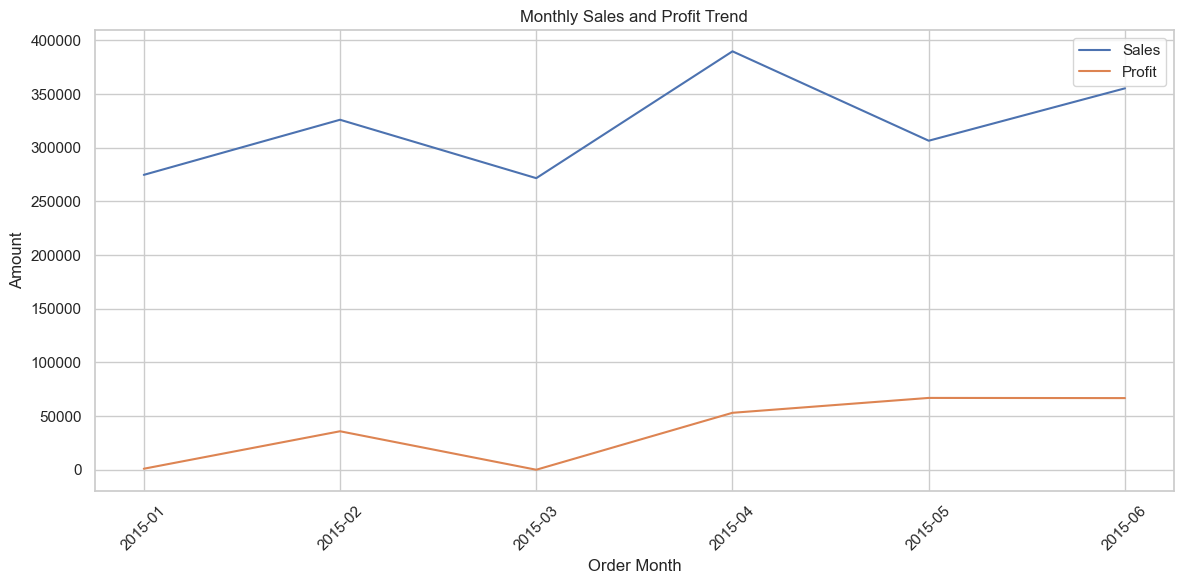

In [13]:
plt.figure()
sns.lineplot(data=monthly_perf, x="Order YearMonth", y="Sales", label="Sales")
sns.lineplot(data=monthly_perf, x="Order YearMonth", y="Profit", label="Profit")

plt.title("Monthly Sales and Profit Trend")
plt.xlabel("Order Month")
plt.ylabel("Amount")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


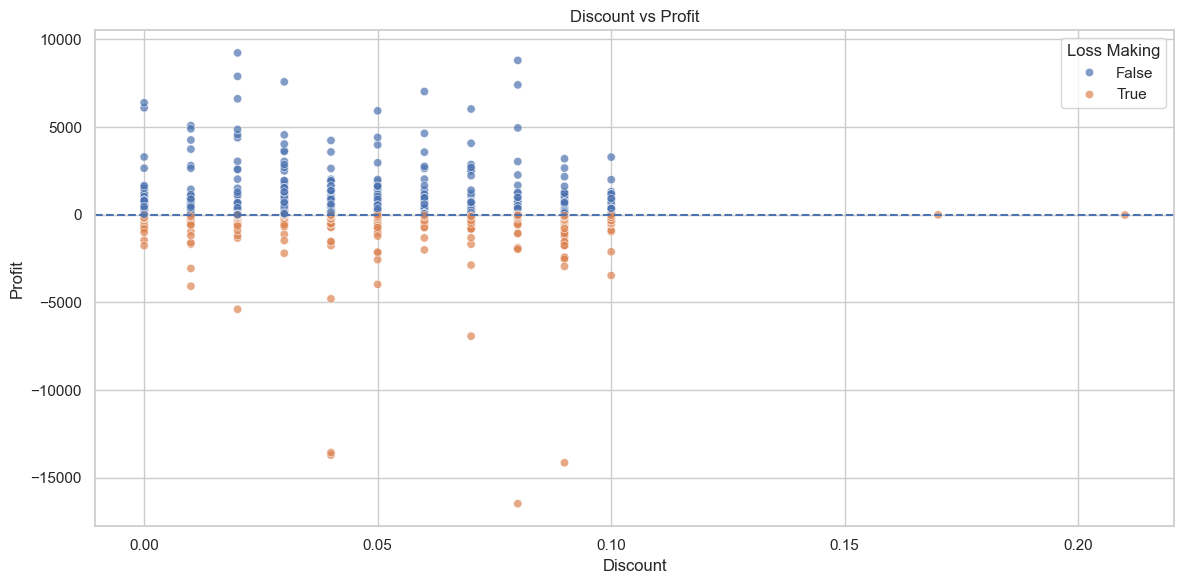

In [ ]:
plt.figure()
sns.scatterplot(
    data=orders_df,
    x="Discount",
    y="Profit",
    hue="Loss Making",
    alpha=0.7
)

plt.title("Discount vs Profit")
plt.xlabel("Discount")
plt.ylabel("Profit")
plt.axhline(0, linestyle="--")  
plt.legend(title="Loss Making")
plt.tight_layout()
plt.show()


In [15]:
loss_by_category = (
    orders_df[orders_df["Loss Making"]]
    .groupby("Product Category")["Profit"]
    .sum()
    .reset_index()
    .sort_values("Profit")
)

loss_by_category


,Product Category,Profit
2,Technology,-127665.850696
0,Furniture,-86461.544780
1,Office Supplies,-77320.644313


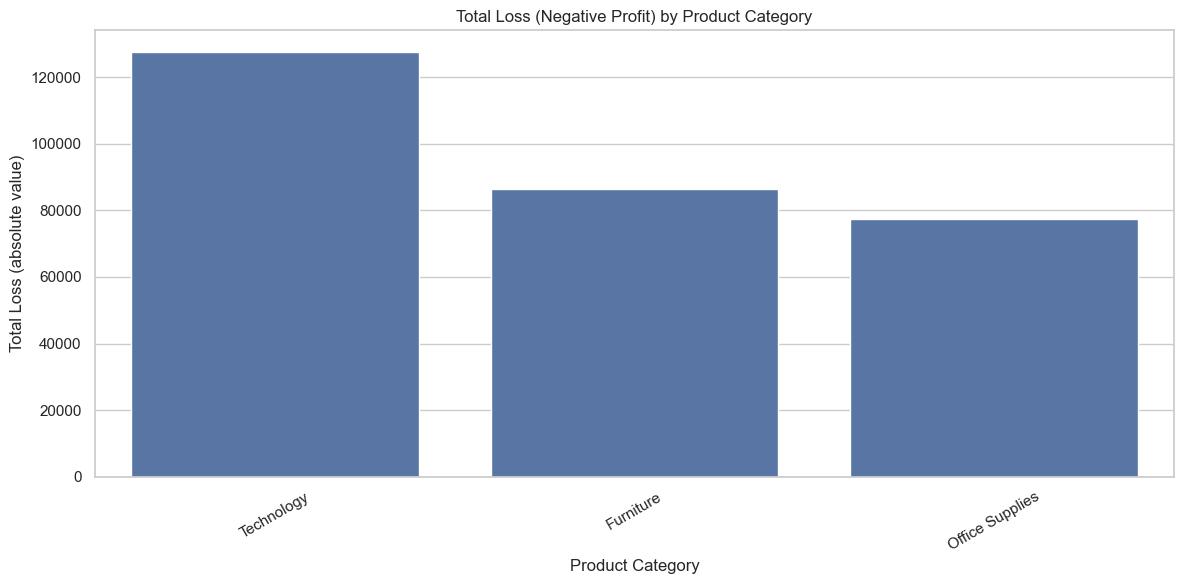

In [ ]:
plt.figure()
sns.barplot(
    data=loss_by_category,
    x="Product Category",
    y=loss_by_category["Profit"].abs()  
)

plt.title("Total Loss (Negative Profit) by Product Category")
plt.xlabel("Product Category")
plt.ylabel("Total Loss (absolute value)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


The cleaned dataset is exported for downstream analysis and Power BI reporting.


In [ ]:

final_file_path = "SuperStore_Cleaned.xlsx"

orders_df.to_excel(final_file_path, index=False)

print(f"Clean dataset exported to: {final_file_path}")


Clean dataset exported to: SuperStore_Cleaned.xlsx
